## Bar

* Мы будем анализировать, в какое время суток пользователи чаще всего делают коммиты, и как это меняется с течением времени.

#### 1. Подключаемся к базе

In [57]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect('../data/checking-logs.sqlite')

#### 2. Загрузка данных

In [58]:
query = """
SELECT timestamp
FROM checker
WHERE uid NOT LIKE 'admin%' AND labname IS NOT NULL
"""
df = pd.read_sql_query(query, conn)

df.head()

,timestamp
0,2020-04-17 05:19:02.744528
1,2020-04-17 05:22:35.249331
2,2020-04-17 05:22:45.549397
3,2020-04-17 05:34:14.691200
4,2020-04-17 05:34:24.422370


#### 3. Определим время суток и сгруппируем

In [59]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

def get_time_of_day(time):
    if 0 <= time.hour < 4:
        return 'night'
    elif 4 <= time.hour < 10:
        return 'morning'
    elif 10 <= time.hour < 17:
        return 'afternoon'
    else:
        return 'evening'

df['time_of_day'] = df['timestamp'].apply(get_time_of_day) 

df['time_of_day'] = pd.Categorical(df['time_of_day'], categories=['night', 'morning', 'afternoon', 'evening'], ordered=True)

df['date'] = df['timestamp'].dt.date

df.head()

,timestamp,time_of_day,date
0,2020-04-17 05:19:02.744528,morning,2020-04-17
1,2020-04-17 05:22:35.249331,morning,2020-04-17
2,2020-04-17 05:22:45.549397,morning,2020-04-17
3,2020-04-17 05:34:14.691200,morning,2020-04-17
4,2020-04-17 05:34:24.422370,morning,2020-04-17


In [60]:
grouped = df.groupby(['date', 'time_of_day'], observed=False).size().unstack(fill_value=0)

grouped.head()

time_of_day,night,morning,afternoon,evening
date,,,,
2020-04-17,0,13,10,0
2020-04-18,0,1,33,35
2020-04-19,2,4,16,11
2020-04-20,0,0,11,13
2020-04-21,0,0,0,25


#### 4. Строим график

<Figure size 1500x800 with 0 Axes>

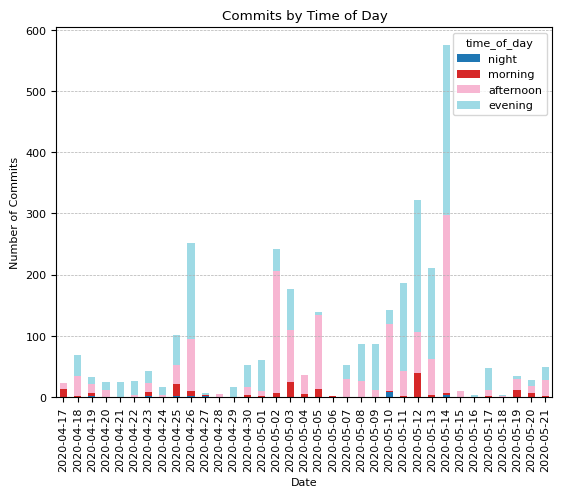

In [61]:
plt.rcParams['font.size'] = 8
plt.figure(figsize=(15, 8))

grouped.plot(kind='bar', stacked=True, colormap='tab20')

plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)

plt.title('Commits by Time of Day')
plt.xlabel('Date')
plt.ylabel('Number of Commits')

plt.xticks(rotation=90)

plt.show()

#### 5. Отвечаем на допы:

##### “When do our users usually commit the labs: in the night, morning, afternoon, or evening?”

In [62]:
most_common_periods = df['time_of_day'].value_counts().nlargest(2).index.tolist()
print(f"The answer is {most_common_periods[0]} and {most_common_periods[1]}.")

The answer is evening and afternoon.


##### Which day has:
* the most number of commits
* and at the same time, the number of commits in the evening is higher than in the afternoon?

In [63]:
commits_on_day = grouped.sum(axis=1)
max_commits_day = None
max_count_commit = 0

for date in commits_on_day.index:
    if grouped.loc[date, 'evening'] > grouped.loc[date, 'afternoon']:
        if commits_on_day[date] > max_count_commit:
            max_count_commit = commits_on_day[date]
            max_commits_day = date

print(f"The answer is {max_commits_day}.")

conn.close()

The answer is 2020-05-12.
